# **Hands-on Part 2/4: Path Reasoning Methods: PGPR & CAFE**

---

![](https://drive.google.com/uc?id=14ccg5Fj1xZoJ1l7EclAoQX1IABlI9kEV)

## **Acknowledgment**

---

The code use in this tutorial directly derives from our [PEARLM Library](https://github.com/Chris1nexus/pearlm). If this tutorial is useful for your research, we would appreciate an acknowledgment by citing our paper:

> Balloccu, G., Boratto, L., Cancedda, C., Fenu, G., & Marras, M. (2023). Faithful Path Language Modelling for Explainable Recommendation over Knowledge Graph. ArXiv, abs/2310.16452.


## **Get Started**

---


### This notebook

By now you should already have the Tutorial folder in your google drive. You just need to mount your drive executing the following line.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


And browse the working directory.

In [ ]:
# Your path to hands on
%cd '/content/drive/MyDrive/ExpRecSys Tutorial Series/2024 ECIR/Hands-On'

/content/drive/MyDrive/ExpRecSys Tutorial Series/2024 ECIR/Hands-On


If you followed Part1, you are ready! 🤘 You can skip the next lines.

### Instead, if you joined late

Open the google drive folder [https://tinyurl.com/ecir2024-tutorial1](https://tinyurl.com/ecir2024-tutorial1) containing the material and follow the instrucions inside `GetStarted.ipynb`

# Outline

---





In the **previous part** we:

1️⃣ Loaded and visualized three datasets beloning to different domains named 📽 ML1M [[1]](#p1), 📀 LFM1M [[2]](#p2), and 📦 Amazon Cellphones [[3]](#p3).

2️⃣ Loaded their Knowledge Graphs (KG) extracted respectively from DBpedia [[4]](#p4), Freebase [[10]](#10), and the dataset's metadata.

3️⃣ Performed some preprocessing steps on both dataset and KG.

4️⃣ Saved datasets and KGs in a **standard format**, that will consent to use our mappers.

In **this part**, you will learn about how to **execute** the PGPR [[10]](#p10) and CAFE [[12]](#p12)
pipeline. This will include map the datasets for the models from standard format, **train** them and **produce** **recommendations** and **explanation paths**.

In this part, we will:

1️⃣ Map our dataset in standard format to a **PGPR readable format** and **CAFE readable format**.

2️⃣ Train the **TransE embedding** [[11]](#p11) used by both PGPR and CAFE.

3️⃣ **Train and extract the predicted paths** from the models.

4️⃣ **Evaluate the models** and convert their path into **texual explanations via templates** [[33]](#p33).

- [ 0 - Packages](#1)
- [ 1 - Prerequisites](#2)
    - [1.1 - Metapaths]()
    - [1.2 - Path Reasoning]()
- [ 2 - Pick your dataset](#2)
    - [2.1 - PGPR data loader](#2.1)
    - [2.2 - Train TransE Embeddings](#2.2)
    - [2.3 - Train Neural Symbolic Symbol](#2.3)
    - [2.4 - Execute Neural Symbolic Symbol](#2.4)
    - [2.5 - Extracting and saving paths](#2.5)


# 0 - Packages

---

In [ ]:
import gzip
import pickle
import pandas as pd
import random
pd.options.mode.chained_assignment = None

For this part we will use a collections of modules that containt mapping functions and the model that we will showcase. Let's install the packages by running the following command

In [ ]:
! pip install .

Processing /content/drive/MyDrive/ExpRecSys Tutorial Series/2024 ECIR/Hands-On
  Preparing metadata (setup.py) ... done
  Created wheel for pathlm: filename=pathlm-0.0.0-py3-none-any.whl size=236948 sha256=4c86b66ebe96e9aeef0a6cfec5a35c9985055f488ea8a7d1c83d9f9d5413d5a0
  Stored in directory: /root/.cache/pip/wheels/5d/d6/fa/857159ee5e51c820ba3cb52d5f60b61adc5ab379954711150d
Successfully built pathlm


# 1 - Prerequisites

---

Previously, we **saved** our datasets and KGs in a **standardized format**. This will be the main **input** for all the models we are going to use. Specifically through our mappers we are going to map the **standard format** to the format required by the model.

*Note: All the models provided in our tutorial have an associated mapper and represent a subset from the one implemented in our [PEARLM library](https://github.com/Chris1nexus/pearlm)*

We will illustrate know **how to use** PGPR and CAFE and some of its **main components**.

🔍 But first let's see some **important concepts**.

## 1.1 Methods that use the KG

In this notebook we focus on Path Based methods **path based** methods exploring the subfamily of **path reasoning methods** [[13](#p13), [15](#p15), [25](#p25), [26](#p26), [27](#p27), [28](#p28), [24](#p24)].

> **Path based methods** [[20](#p20), [21](#p21), [22](#p22), [23](#p23), [24](#p24)]: Leverage the KG **explictly** (or in both ways) and leverage the paths to produce explanations. These explanation paths can be easily converted into a **textual explanation**.

**Path Reasoning methods** are able to extract paths and recommendations in the **same step**. This guarantees a **high fidelity** since the produced explanation path encode the real model functioning.

A path reasoning method addresses the KGRE-Rec task.
> **KGRE-Rec task**: Given a knowledge graph $\mathcal G$ and an integer $K \in \mathbb N$ representing the maximum hop length, the goal is learning a model $\theta : (\mathcal U, \mathcal P, \mathcal L^k) \rightarrow \mathbb R^2$ able to estimate (i) the point-wise relevances $ \mathcal F(u, p) \in [0, 1]$ for unobserved entries in $\mathcal F$ and (ii) the probabilities $\mathcal S(l_{u,p}) \in [0, 1]$ that a path $l_{u,p} \in \mathcal L^k_{u,p}$ is followed to reach product $p$ from user $u$ in $\mathcal G$, with $2 < k \leq K$.

## 1.2 Paths as explanations

Knowledge graphs **paths** are composed by a chain of **entities** and *relations*. For the task of **explainable recommendation**, we are interested in user-centric paths [[33]](#p33) that **start** from a **user entity** and **end** with a **product entity**.

Let's take (**user A**, *watched*, **movie A**, *starring-1*, **Actor A**, *starring*, **Movie B**) as example path.

*Note: In text bold represent entity, italic relation*. The **reverse relation (^-1)** represents the **passive relation** (starred_by), the **forward relation** (starring) represents the **active relation**.

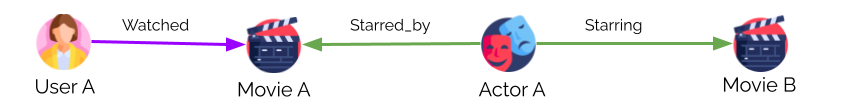

These paths are **intuitive by nature**, since they represent **human understandable** relations between items and external entities.


However, **not** every path **makes sense** for the explanation purpose. Let's take two paths as examples.
In the first one, we can see that this path has a **length of 2** (two relations) and ends up with an external entity. Therefore, an item cannot be reached with such a lenght (based on our relations) and we cannot recommend a product.

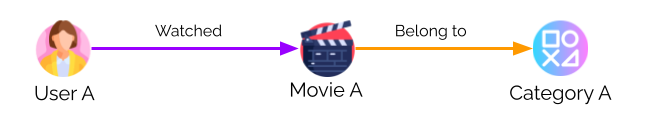

As second example, this path is **not user-centric** because it **doesn't start** with a **user** and it **doesn't end** with a **product**.

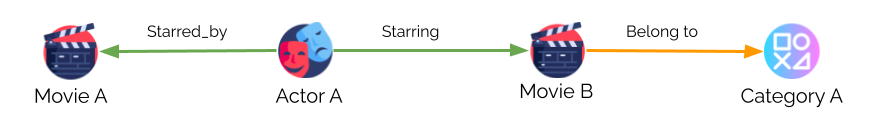

To constraint the possible paths and select only those that follow some structured rules (based on length and semantics) what is done is to define **meta-paths**.

> A metapath, is relation sequence connecting
two entities. Is proposed to capture the structural and semantic relation between objects.

For example the metapath: *(watched, starred_by, starring)* connects a **user to a movie through an external entity** (actor in this case).

👍 A great property of the paths is that they are a **great source to produce textual explanations** and some methods are able to **extract them while performing recommendations**. This is particular useful since in this way the **path encodes the real model functioning**. Paths have this property and are composed with a **step-by-step** approach take the name of **reasoning paths**.

👎 However, **defining effective metapaths still necessitates domain knowledge and manual effort**, it does not discover unseen or personalized connectivity patterns.

## 1.3 TransE Embedding

TransE [11] is a **translational knowledge graph embedding** (KGE). KGE methods [27, 28, 29] aims to learn a low-dimensional representation of a KGs' entities and relations while preserving their semantic meaning. TransE interprets relationships as translations in the embedding space. Specifically, for a given relation $r$ between entities $h$ (head) and $t$ (tail), TransE models the relationship by aiming to ensure $h + r \approx t$ in the embedding space.

![](https://drive.google.com/uc?id=1k-h0kNfEvT5gL4s_zQAEtMv4R2xJSfUS)


In PGPR, the use of TransE can be outlined as follows:

- **Multi-Hop scoring function**: Guides the agent exploration (path selection), favoriting the paths with the highest value. It is calculated doing the dot product between the current node and the candidate node.

- **Reward function**: Assigns the reward to the path. It is calculated by doing the dot product between the first node of the path and the end node.

In the context of the CAFE (Coarse-to-Fine Neural Symbolic Reasoning for Explainable Recommendation) framework, TransE is employed as a part of the symbolic reasoning process to generate embeddings for entities and relations within the knowledge graph.

While in CAFE, the use of TransE can be outlined as follows:

- **Coarse Reasoning Phase**: CAFE leverages these embeddings during its coarse reasoning phase. In this phase, the embeddings are used to quickly generate candidate explanations for recommendations by exploring the knowledge graph. The embeddings help in identifying potentially relevant paths that link users to items (products) through various intermediate entities and relations, serving as a basis for further exploration.



## 1.4 Policy Guided Path Reasoning (PGPR)

PGPR is a **Self-Explainable recommendation** method that relies on a **Reinforcement Learning** (RL) agent conditioned on the user and trained to navigate to potentially relevant products. Starting from a user node, the agent will conduct an **explicit multi-step path reasoning over the graph**, so as to discover suitable items in the graph for recommendation to the target user. The path from the user A to the product can be used **to explain the recommendation.**

To model a **RL problem** we need to define 4 things:
- `Enviroment`: The KG
- `Set of States`: Nodes of the KG
- `Set of Actions`: Edges of the KG
- `Reward`: Computed using transE embedding


To use RL on the KG (enviroment) PGPR models the **nodes** of the KG as **states** and the **out going edges for a node** as possible **actions**.

To learn more about how this is done you can check the `kg_env.py` file.

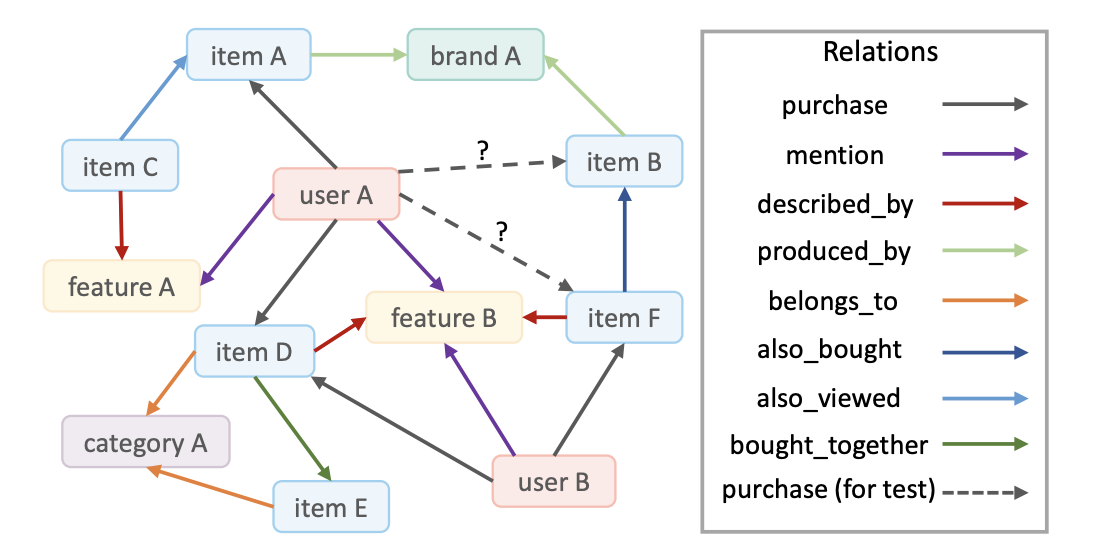

Here you can see that, from user B (state) in the image, we have 3 different actions (edge) to reach another state (node):
- (*mentioned*, **feature B**)
- (*purchase*, **item F**)
- (*purchase*, **item D**)

During the learning, the agent starts from a random user node (state), and will search for valid paths (according to our metapaths) that bring to a product composing the path **step-by-step** until **we reach a product**.

The **Action Space** (which action we can take as next) is done by considering both **random actions** (exploration) and actions that maximize the **scoring function** (exploitation).

To handle the possible high amount of actions avaiable, the authors also proposed a **pruning based on the scoring function**.


The **Multi-Hop scoring function** for a path of len *k* is defined as the sum of the dot product in the translational space (<...>) between the entities that compose the path.

Specifically, considering the path (e<sub>0</sub>, r<sub>0</sub> e<sub>i</sub>, r<sub>k-1</sub>, e<sub>k-1</sub>, r<sub>k</sub> e<sub>k</sub>):

> **Multi-hop scoring function**: $ f(e_0, e_k) = \sum_{i=0}^{k} < e_i, e_{i+1} > $

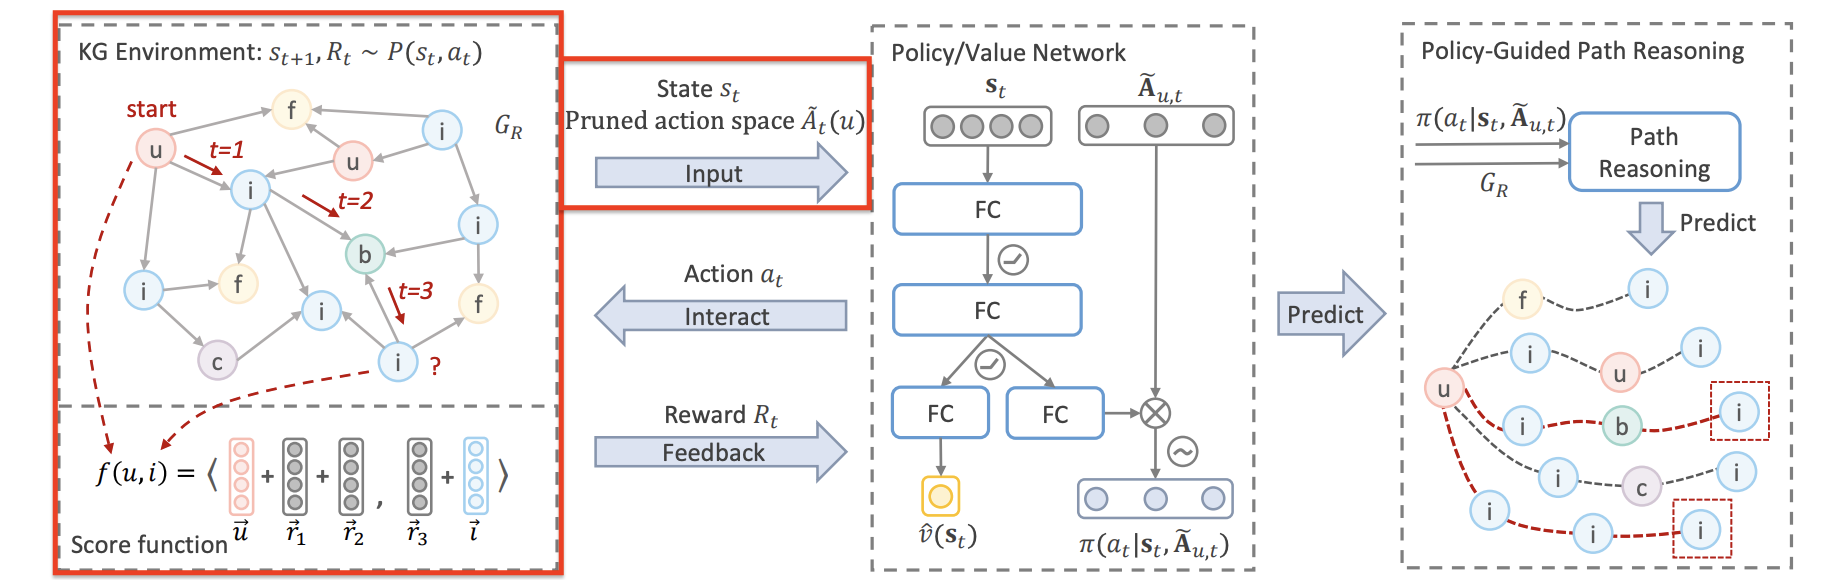

When a product is reached, the process ends. And the **reward is given as feedback** to the Policy/Value Network. The score function is calculated as the dot product in the translational space (<...>) between the user (e<sub>0</sub>) and the product (e<sub>k</sub>):

> **Reward function**: $R_t = \{ <e_0, e_k> | \; e_0 \in U, \; e_k \in P\}$

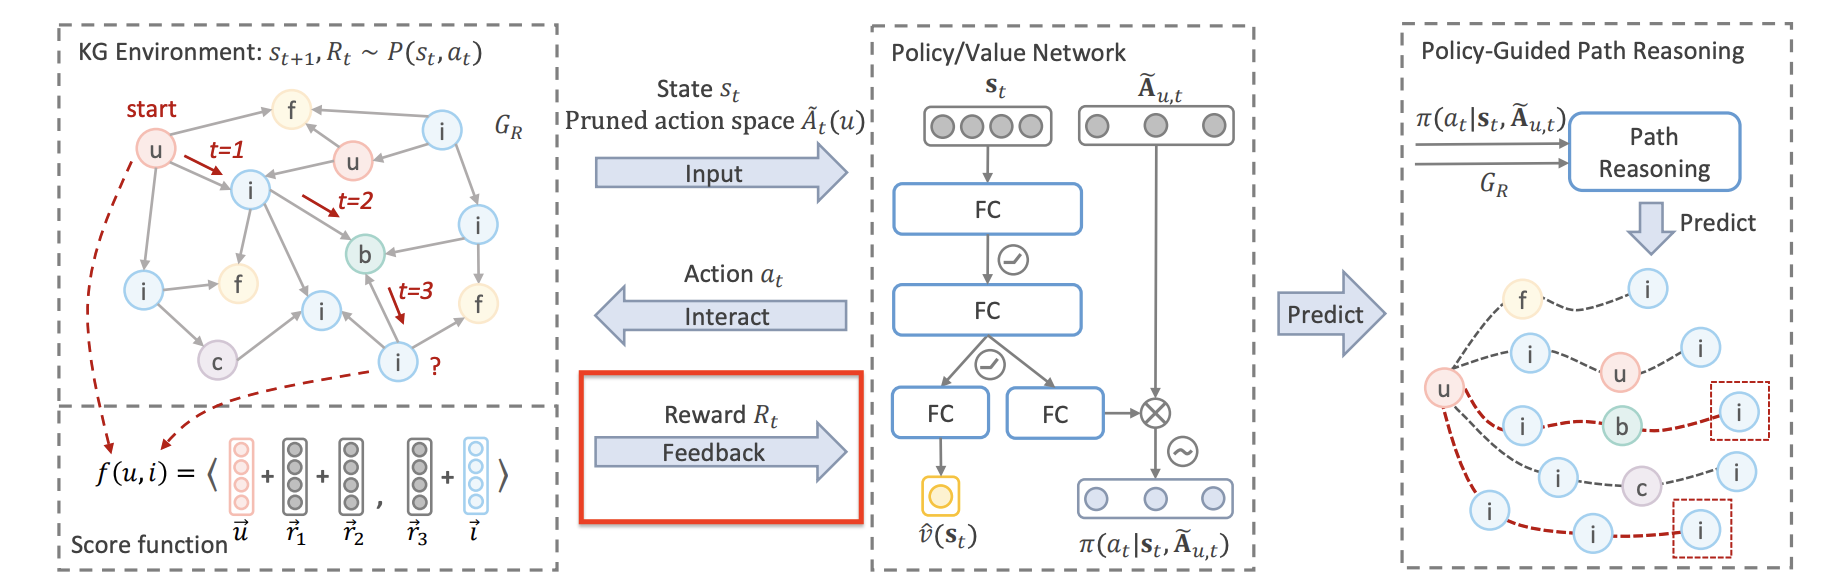

After the training step, we have a learned **Policy/Value Network** $\pi$. From the policy we can retrive what is the probability for an action $a_t$ given the current state $s_t$ at step $t$ and the action space $A_{{s_t},{s_t+1}}$.

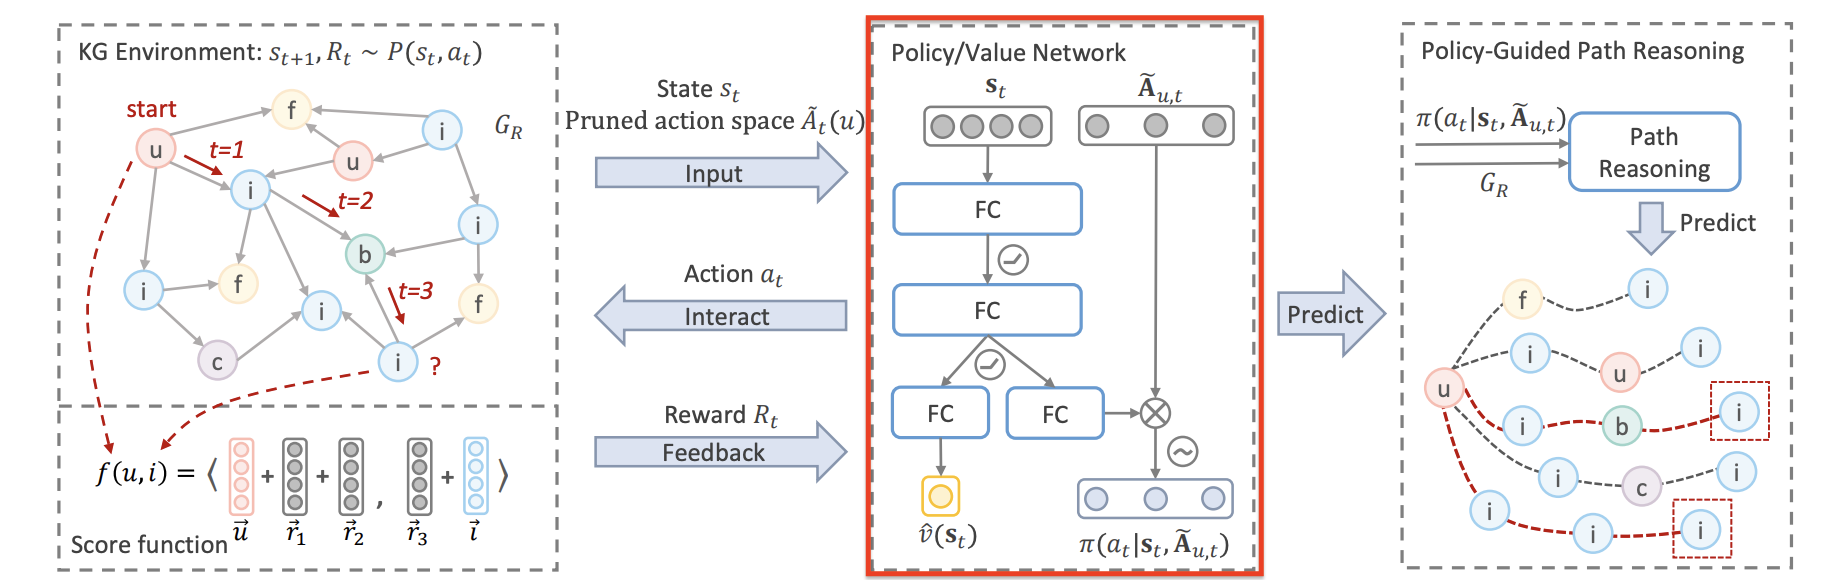

Finally, in the last step, we use the **learned policy** $\pi$ to guide the **path reasoning for inference**. Starting from a user $u$ we start a **beam search** selecting the best $[Z_0, ..., Z_t]$ actions based on their policy value $\pi(a_t | s_t, A_{u,t})$.

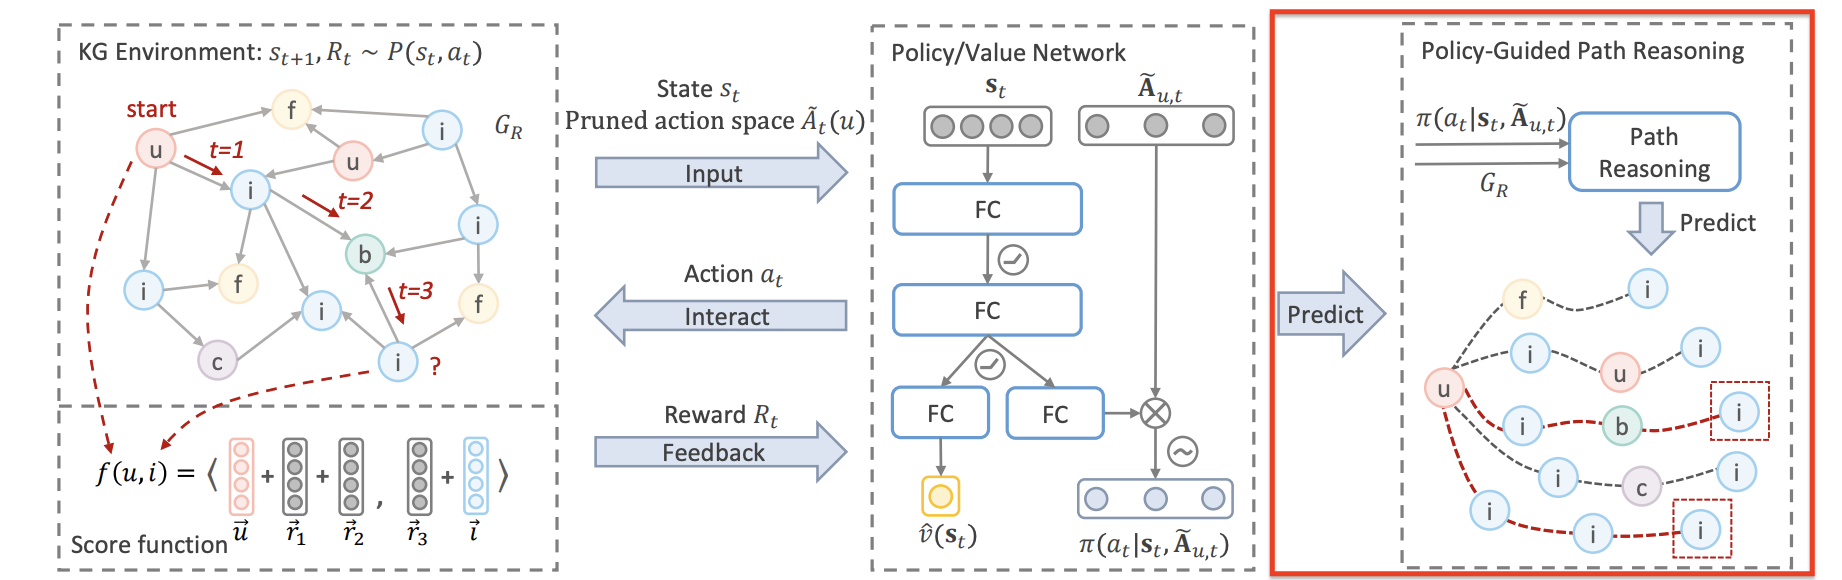

## 1.5 Course to Fine Path Reasoning (CAFE)

The Cafe algorithm has the same task of PGPR. Given a KG and a start user, the goal is to conduct **multi-step path reasoning** to derive **recommendations**.

In particular, it creates a set of **User Profiles** to identfy **promiment path patterns** (e.g., metapaths that have higher sensibility with the user) and **a group of Neural Symbolic Reasoning Modules** (instead of one agent).
The path inference is structured using a **Layout Tree** which offers more efficiency compared to PGPR.

Here, you can see the main components of CAFE:

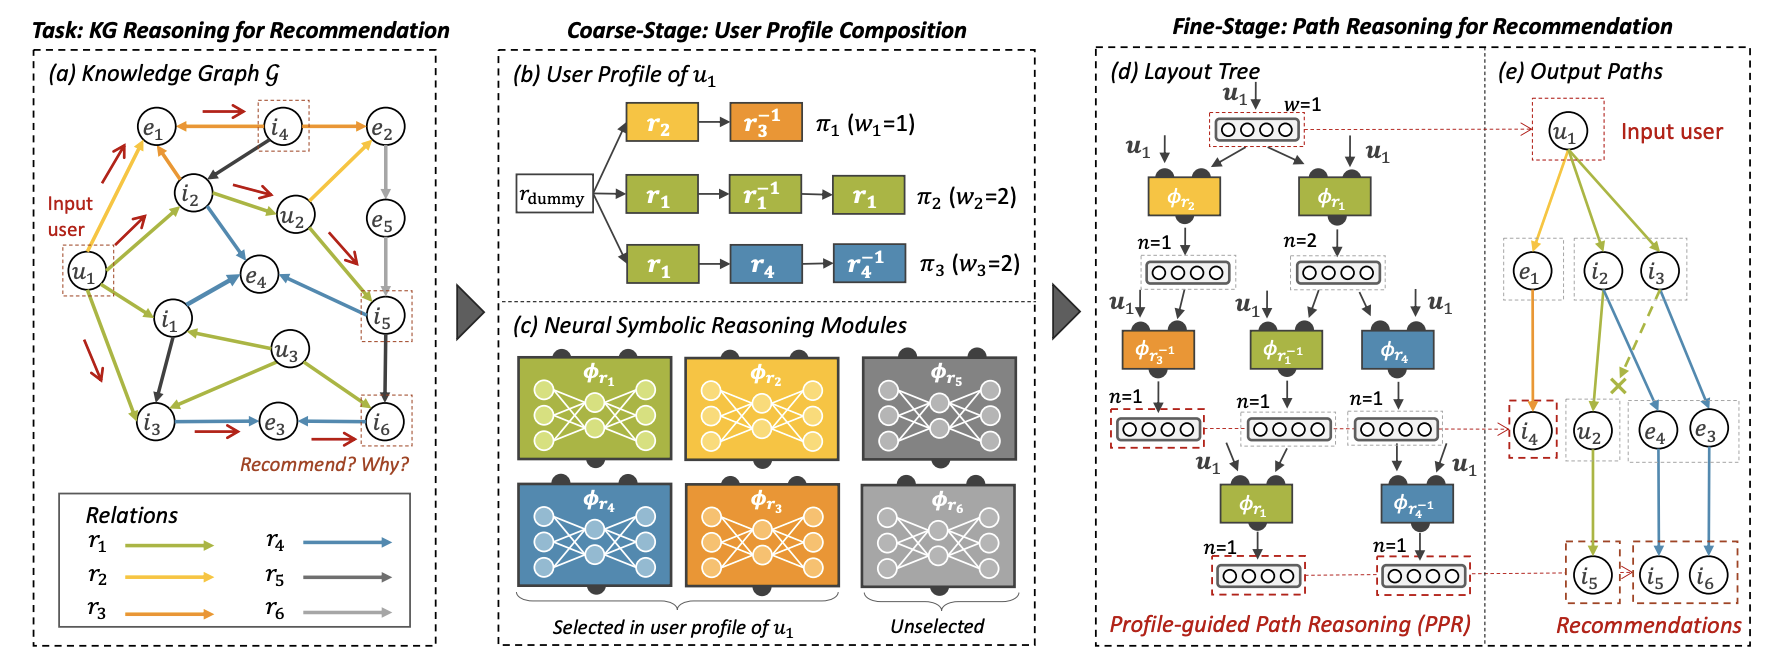

In the **coarse stage (b)**, a personalized user profile is constructed based
on historic user behavior in the KG. To make use of the **user profile (c)** in path reasoning, an inventory of neural symbolic
reasoning modules is maintained. In the **final stage (d)**, a **layout tree** is composed with the modules based on the user profile,
which is exploited by the proposed **PPR algorithm** to produce **(e) a batch of paths along with recommendations**.

# 2. Training TransE Knowledge Graph Embedding



---

In this part of the tutorial, you can chose to proceed with `ml1m` or `lfm1m`. We will use `lfm1m` but you are free to chose. All the pre-trained models for these datasets are available, while for the `cellphones` dataset we will release it soon, in the [offical github tutorial repository](https://github.com/explainablerecsys/ecir24) to reduce the size of this tutorial folder. In notebook 4 we will show the entire pipeline also with the educational `COCO` dataset.

In [ ]:
dataset_name = "ml1m"

## 2.1 Data mapper

---

To run **PGPR and CAFE**, we firstly need to train the KG representation through a knowledge graph embedding method. Both methods rely on the TransE embedding.

To train TransE we must have all the **entities** (e.g., actor, category) and **relations** (e.g. starring, belong to) **grouped by their type**.

To do that, let's use the script `map_dataset.py` from the `data_mappers` module takes as **arguments** the following parameters:
- `dataset_name`: One among `{ml1m, lfm1m, cellphones, coco}`
- `model_name`: One among `{transe, pgpr, cafe}`

Let's run this step for TransE

In [ ]:
! python pathlm/data_mappers/map_dataset.py --data {dataset_name} --model transe

The model selected saves in preprocessed/mapping/ directory
Creating data/lfm1m/preprocessed/mapping/ filesystem
/usr/local/lib/python3.10/dist-packages/pathlm/data_mappers/mapper_pgpr.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  triplets_grouped_by_rel.entity_head = triplets_grouped_by_rel.entity_head.map(eid2new_id[PRODUCT])
/usr/local/lib/python3.10/dist-packages/pathlm/data_mappers/mapper_pgpr.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  triplets_grouped_by_rel.entity_tail = triplets_gro

Internally, it will extract entities from our KG standard format and **group all entities and relations by their type**.

For example, in the triplet (**movie A**, *belong to*, **Category A**), the relation *belong to* tells us that the entity tail will be a category. Exploiting **this semantic rules** it will create `number_of_entity_types` files, where everyone of them stores incremental `entity local ids` for that entity type.

Something similar is done for relations.

We can therefore expect **two main files types**:
- **Entities:** are files that contain the entities id for the corresponding entity. They are remapped from 0 to number of entities of the corresponding type.
- **Relations:** are files that contain the relations. Every file has `n_products` number of rows and every row defines the relation between that product and a list of entities.

This mapping is output in `preprocessed/mapping`

In [ ]:
! ls data/{dataset_name}/preprocessed/mapping

artist.txt.gz		   mixed_by_engineer.txt.gz	product.txt	user_mapping.txt
belong_to_genre.txt.gz	   pgpr_backup.zip		product.txt.gz	user.txt
engineer.txt.gz		   produced_by_producer.txt.gz	test.txt.gz	user.txt.gz
featured_by_artist.txt.gz  producer.txt.gz		train.txt	valid.txt.gz
genre.txt.gz		   product_mapping.txt		train.txt.gz


Let's see, as an example, the file for the `editor` entity_type named `editor.txt.gz`.  

In [ ]:
with gzip.open("data/ml1m/preprocessed/pgpr/editor.txt.gz", 'rt') as editor_file:
    for i, line in enumerate(editor_file):
        if i > 5: break
        print(line)
editor_file.close()

new_id	eid

0	5696

1	4834

2	8682

3	7102

4	11658



Every row is composed by a `new_id` that defines the `local id` of the entity w.r.t the entity type. And in the column `name` we have the id of that entity in the **KG in standard format**.

Let's see now an example of relation file, let's take `category_p_ca.txt.gz`.

In [ ]:
with gzip.open("data/ml1m/preprocessed/pgpr/belong_to_category.txt.gz", 'rt') as belong_to_file:
    for i, line in enumerate(belong_to_file):
        if i > 5: break
        print(line)
belong_to_file.close()

55	5	1222	170	152	525	851	177	726	256	1790	284	19	974

42	373	1023	37	1607	1631	29	1007	303	165	1223	1686	101	1131	100	821	647	328

37	579	5	556	311	267	1153	16	170	22	139	835

180	347	27	1459	37	5	519	1131	1328	25	979	1046

32	90	1042	5	569	643	363	89	22	95	1282	478	412	366

577	932	37	95	561	627	5	662	130	465	14	12	800	96	1785	1744



In these files, the **row number** represent the **id** of the product entity, from `0, ..., n_products` and the **content of the row** is composed by the **local entity ids**. So, in the example product, 1 has a `belong_to` relation with `40450,	39274,	34933,	40132,	...`.

## 2.2 Train TransE Embedding

---

Since the methods we are going to train in this notebook have dependecies with the TransE embeddings we firstly learn the **TransE representation** of our KG by executing the `train_transe_model.py`.

The transE hyperparameter list is reported as follow:
- `--epochs`: number of epochs to train.
- `--batch_size`: batch size.
- `--lr`: learning rate
- `--weight_decay`: weight decay for adam.
- `--l2_lambda`: l2 normalization
- `--max_grad_norm`: clipping gradient
- `--embed_size`: knowledge embedding size.
- `--num_neg_samples`: number of negative samples.

For simplicity, we have already set the values so we can just run the script indicating the `dataset_name`.

⚠️ We have already the **precomputed transE for all datasets**. So you **don't need** to run this command now.

⏲️ Estimate time: 1h with `ML1M`

In [ ]:
! python pathlm/models/embeddings/train_transe_model.py --dataset {dataset_name}

The output will be save into `weights/<dataset_name>/embeddings` as a `.pkl` file named `transe_embed.pkl`

In [ ]:
! ls weights/{dataset_name}/embeddings

ckpt  transe_embed.pkl


✅ Done! We now have the TransE embedding that will be used by PGPR, CAFE and PLM (in the next notebook).

# 3. PGPR train pipeline

---

![](https://drive.google.com/uc?id=1aP6Sg7WBhEVuK-Ln7pqzVqcu4efOK5Ea)



The PGPR pipeline is composed by three main components:

- **KG Object creation**: The `preprocess.py` creates the KG and Dataset objects necessary for instantiate the KG Environment.
- **Train of the Policy/Value Network**: Through the `train_agent.py` an Actor-Critic architecture a Policy/Value is learned using as reward signal the TransE embedding score between adjacent nodes.
- **Policy-Guided Path Reasoning**: Through the `test_agent.py` the Policy learned in the previous step a beam search algorithm is employed to produce the final paths and associated recommendations.

In [ ]:
curr_model = 'pgpr'

## 3.1 - Prepare data for PGPR data Loader
---

To run PGPR, as TransE, we need to have the files in a format which is readable by the model.

To do that, let's use the script `map_dataset.py` from the `data_mappers` module takes as **arguments** the following parameters:
- `dataset_name`: One among `{ml1m, lfm1m, cellphones, coco}`
- `model_name`: One among `{transe, pgpr, cafe}`

Let's run this step for TransE which will be trained and later used by PGPR, CAFE and PLM

In [ ]:
! python pathlm/data_mappers/map_dataset.py --data {dataset_name} --model {curr_model}

Creating data/ml1m/preprocessed/pgpr/ filesystem
/usr/local/lib/python3.10/dist-packages/pathlm/data_mappers/mapper_pgpr.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  triplets_grouped_by_rel.entity_head = triplets_grouped_by_rel.entity_head.map(eid2new_id[PRODUCT])
/usr/local/lib/python3.10/dist-packages/pathlm/data_mappers/mapper_pgpr.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  triplets_grouped_by_rel.entity_tail = triplets_grouped_by_rel.entity_tail.map(eid2new_id[entity_name])
/usr/local/

Since TransE and PGPR have the same dataloader this process will create identical files to the one created for TransE.

But the output will be saved in `preprocessed/pgpr`

In [ ]:
! ls data/{dataset_name}/preprocessed/{curr_model}

actor.txt.gz				  edited_by_editor.txt.gz	  starred_by_actor.txt.gz
belong_to_category.txt.gz		  editor.txt.gz			  test.txt.gz
category.txt.gz				  mappings			  tmp
cinematographer.txt.gz			  prodcompany.txt.gz		  train.txt.gz
cinematography_by_cinematographer.txt.gz  produced_by_prodcompany.txt.gz  user.txt.gz
composed_by_composer.txt.gz		  produced_by_producer.txt.gz	  valid.txt.gz
composer.txt.gz				  produced_in_country.txt.gz	  wikipage.txt.gz
country.txt.gz				  producer.txt.gz		  writter.txt.gz
directed_by_director.txt.gz		  product.txt.gz		  wrote_by_writter.txt.gz
director.txt.gz				  related_to_wikipage.txt.gz


✅ Done! Let's now create the dataset and kg objects.

## 3.2 - Run PGPR preprocessing

---

Now, the last thing to do before training the agent is to run the `pathlm/models/rl/pgpr/preprocess.py`.

This PGPR code takes as input the `dataset_name` and uses it to located the files that we have created in the previous step.

Internally, it will use these files to instantiate a class object dataset and a class object KG. These objects are then stored in the `data/<dataset>/preprocessed/pgpr/tmp` folder for loading them later.

In [ ]:
! python pathlm/models/rl/pgpr/preprocess.py --dataset {dataset_name}

python3: can't open file '/content/drive/MyDrive/ExpRecSys Tutorial Series/2024 ECIR/Hands-On/pathlm/models/rl/pgpr/preprocess.py': [Errno 2] No such file or directory


In [ ]:
! ls data/{dataset_name}/preprocessed/{curr_model}/tmp

dataset.pkl  kg.pkl  pgpr_hparams_file.json  test_label.pkl  train_label.pkl  valid_label.pkl


✅ Done! We are ready to learn the policy

## 3.3 - Train Agent
---



![](https://drive.google.com/uc?id=1-CdHZELMLM7Jz0TsZJnMsfA529Km0PVr)

We are now going to learn the policy $\pi$. The goal is to find a **policy that maximizes the cumulative reward**. This is done mainly by this steps:

- In each episode, the **agent** will **start** from a **user state** (node) randomly sampled.

- For that step, we evaluate all the **possible valid actions (out-going edges)** from that state, sort them by **multi-hop scoring** and take the ones with the **higher score**. This will cause multiple paths getting generated at the same time.

- We repeat the previous step until we reach the **desidered length** and the **current state (node) is a product**. We compute there the reward for that path which is given to the **policy**.

> **Multi-hop scoring function**: $ f(e_0, e_k) = \sum_{i=0}^{k} < e_i, e_{i+1} > $

> **Reward function**: $R_t = \{ <e_0, e_k> | \; e_0 \in U, \; e_k \in P\}$

The policy $\pi$ will store a probability score of taking an action $a_t$ given the current state $s_t$ at step $t$ and the action space $A_{{s_t},{s_t+1}}$.

We can learn the policy by executing `pathlm/models/rl/pgpr/train_agent.py`.

The train_agent hyperparameter list is reported as follows:
- `--epochs`: Max number of epochs.
- `--batch_size`: Batch size.
- `--lr`: Learning rate.
- `--max_acts`: Max number of actions.
- `--max_path_len`: Max path length.
- `--gamma`: reward discount factor.
- `--ent_weight`: weight factor for entropy loss.
- `--act_dropout`: action dropout rate.
- `--state_history`: state history length.
- `--hidden`: Number of samples.

For simplicity, **we have already set the values** so we can just run the script indicating the `dataset_name`.

⚠️ We already have the **precomputed policy for all datasets**. So you **don't need** to run this command now. The `policy_model_epoch50.pkl` file will be store in `data/{dataset_name}/preprocessed/pgpr/tmp/train_agent`

⏲️ Estimate time: 20m with `ML1M`

In [ ]:
! python pathlm/models/rl/pgpr/train_agent.py --dataset {dataset_name}

In [ ]:
! ls weights/{dataset_name}/{curr_model}

ckpt  policy_paths_epoch50.pkl	train_agent


✅ Done! From the predicted policy we can now extract the predicted paths and associated recommendations.

## 3.4 - Extract paths from policy
---

The only remaining step is to **extract the paths** from the previously learned policy $\pi$.

![](https://drive.google.com/uc?id=15uAPlc6EVAXz5MdLi62UYUOshcFcPjCX)

This is done by executing a **beam search** using as score for every step the probability $\pi(a_t | s_t, A_{u,t})$.


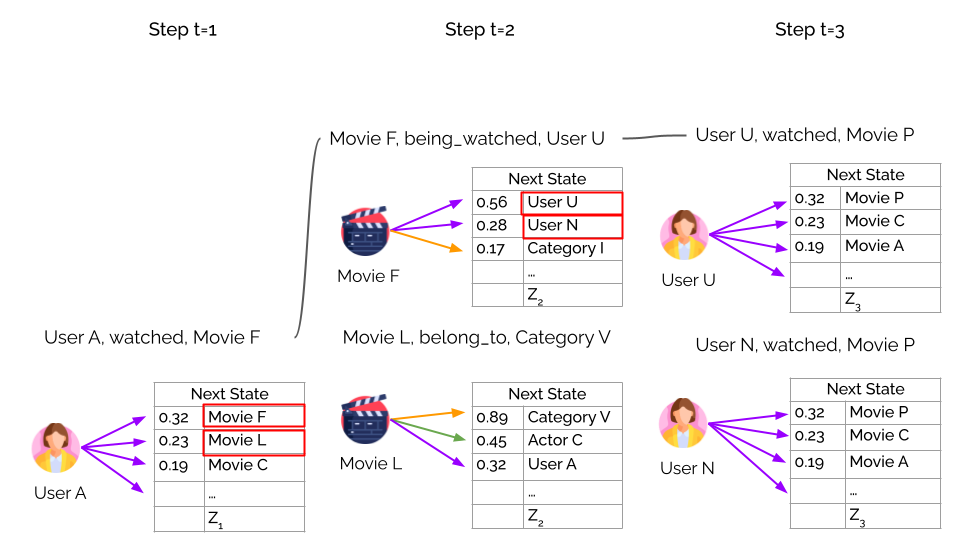

Starting from the user at step $t=1$, the model will compute a ranked list based on the $\pi(a_t | s_t, A_{u,t})$ value. It will select the first $Z_1$ actions and from each of them **will recursively repeat this process** until the path length $T$ is reached ($t=T$). All the produced paths are stored in and can be used to produce the final top-$n$.

We can extract the paths by using the **beam search** running `test_agent.py`.

The test_agent hyperparameter list is reported as follow:
- `--epochs`: Max number of epochs.
- `--max_acts`: Max number of actions.
- `--max_path_len`: Max path length.
- `--gamma`: reward discount factor.
- `--hidden`: Number of samples.
- `--act_dropout`: Action dropout rate.
- `--state_history`: State history length.
- `--topk`: number of samples for the batch beam search. (e.g. [Z1, Z2, Z3])
- `--run_path`: Generate predicted path? (takes long time)
- `--run_eval`: Run evaluation?

For simplicity, we have already set the values so we can just run the script indicating the `dataset_name`.

⚠️ We already have the **paths extracted from the policy for all datasets**. So you **don't need** to run this command now. The `policy_paths_epoch50.pkl` file will be stored in `weights/{dataset_name}/pgpr/`

⏲️ Estimate time: 25m with `ML1M`

In [ ]:
! python pathlm/models/rl/pgpr/test_agent.py --dataset {dataset_name}

The predicted paths stored in `policy_paths_epoch50.pkl` have also been sorted base on probability and used to create the top`k` (`k`=10) of items and paths which will be store in `results/dataset/pgpr`.

In [ ]:
! ls weights/{dataset_name}/pgpr

ckpt  policy_paths_epoch50.pkl	train_agent


✅ We are done! Let's now evaluate the performance of our model

## 3.5 - Evaluating results

---

The final top`k` of predicted item stored in `results/<dataset>/pgpr/top{k}_items.pkl` as dictionary where each key is a user and its value the k recommended items.

In [ ]:
pgpr_results_path = f'results/{dataset_name}/{curr_model}'

In [ ]:
with open(f"{pgpr_results_path}/top10_items.pkl", 'rb') as pred_top_items_file:
    pgpr_item_topks = pickle.load(pred_top_items_file)
pred_top_items_file.close()

In [ ]:
list(pgpr_item_topks.items())[:5]

[(0, [2240, 2942, 2069, 1694, 2371, 2712, 2009, 2235, 2585, 2812]),
 (1, [1877, 1824, 2913, 2582, 2742, 1462, 2907, 2102, 1359, 2235]),
 (2, [2151, 2102, 1462, 2261, 2906, 2240, 1329, 1249, 2444, 2215]),
 (3, [1462, 2648, 1188, 1329, 322, 2261, 2102, 2585, 1694, 2235]),
 (4, [1063, 1715, 2712, 2936, 2035, 960, 2235, 2887, 1810, 1697])]

Meanwhile the associated explanations are stored in `results/<dataset>/pgpr/top{k}_paths.pkl`

In [ ]:
with open(f"{pgpr_results_path}/top10_paths.pkl", 'rb') as pred_top_paths_file:
    pgpr_path_topks = pickle.load(pred_top_paths_file)
pred_top_paths_file.close()

In [ ]:
list(pgpr_path_topks.items())[0]

(0,
 [[('self_loop', 'user', 0),
   ('watched', 'product', 2787),
   ('watched', 'user', 4992),
   ('watched', 'product', 2240)],
  [('self_loop', 'user', 0),
   ('watched', 'product', 878),
   ('watched', 'user', 2542),
   ('watched', 'product', 2942)],
  [('self_loop', 'user', 0),
   ('watched', 'product', 644),
   ('watched', 'user', 4527),
   ('watched', 'product', 2069)],
  [('self_loop', 'user', 0),
   ('watched', 'product', 2433),
   ('watched', 'user', 932),
   ('watched', 'product', 1694)],
  [('self_loop', 'user', 0),
   ('watched', 'product', 2785),
   ('watched', 'user', 2284),
   ('watched', 'product', 2371)],
  [('self_loop', 'user', 0),
   ('watched', 'product', 835),
   ('watched', 'user', 4398),
   ('watched', 'product', 2712)],
  [('self_loop', 'user', 0),
   ('watched', 'product', 2787),
   ('watched', 'user', 3935),
   ('watched', 'product', 2009)],
  [('self_loop', 'user', 0),
   ('watched', 'product', 2787),
   ('watched', 'user', 4153),
   ('watched', 'product', 

To evaluate the produced topks we can use the `pathlm/evaluation/evaluate_results.py` script that will calculate the following metrics:

- **NDCG: (Normalized Discounted Cumulative Gain)** The extent to which the recommended products are useful for the user. Weights the position of the item in the top-k.

$$NDCG@k=\frac{DCG@k}{IDCG@k}$$

$DCG@k = \sum_{i=1}^{k} \frac{2^{rel_i} - 1}{\log_2(i+1)}$ measures the total relevance of the top-k recommended items, discounting the relevance based on their position in the list. Higher relevance items are more valuable at higher ranks.

$IDCG@k = \text{sort descending}(rel)$ is the ideal DCG at k, calculated by sorting all relevant items in descending order before applying the DCG formula. This represents the best possible arrangement of items based on their relevance.



- **MMR:** The extent to which the first recommended product is useful for the user.

$$MMR = \frac{1}{\text{first hit position}}$$

- **Coverage:** Proportion of items recommended among all the item catalog.

$$\frac{| \text{Unique Recommended items}|}{| \text{Items in Catalog} |}$$

- **Diversity:** Proportion of genres covered by the recommended items among the recommended items.

$$\frac{| \text{Unique Genres} |}{| \text{Recommended items} |}$$
- **Novelty:** Average inverse of popularity of the items recommended to the user
$$\frac{\sum_{i \in I}| 1 - \text{Pop}(i) |}{| \text{Recommended items} |}$$

- **Serendipity:** Proportion of items which may be surprising for the user, calculated as the the proportion of items recommended by the benchmarked models that are not recommended by a prevedible baseline. In our case the baseline was MostPop.

$$\frac{| \text{Recommended items} \cup \text{Recommended items by most pop} |}{| \text{Recommended items} |}$$

This metrics have been implemented and benchmarked for many models in our ECIR23 reproducibility work [[36]](#p36). We point to it for more information about the metrics and the performance of various models.

In [ ]:
! python pathlm/evaluation/evaluate_results.py --dataset {dataset_name} --model {curr_model} --k 10

Evaluating rec quality for ['ndcg', 'mrr', 'precision', 'recall', 'serendipity', 'diversity', 'novelty']: 100% 6040/6040 [00:00<00:00, 6698.04it/s]
Number of users: 6040, average topk size: 10.00
ndcg: 0.25, mrr: 0.18, precision: 0.09, recall: 0.04, serendipity: 0.72, diversity: 0.85, novelty: 0.92, coverage: 0.39


## 3.7 - Textual Explanation generation

---

So far we have seen the explanations as paths. To convert the explanations to plain text, we need to **substitute the entities IDs with their name**. To do that let's load **these mappings** for both models using the `get_local_eid_to_name` function from the `pathlm.datasets.data_utils` module.

*Note: The path predicted by PGPR and CAFE have local ids so we need a mapping for (entity_type, local_id) to name*

In [ ]:
from pathlm.datasets.data_utils import get_local_eid_to_name
eid_type2local_eid2name = get_local_eid_to_name(dataset_name)
eid_type2local_eid2name['product'][0]

'http://dbpedia.org/resource/The_Phantom_of_the_Opera_(1925_film)'

In [ ]:
# Path Structure: [('self_loop', 'user', 0), ('watched', 'product', 2433), ('watched', 'user', 932), ('watched', 'product', 1694)],
def template(path):
    path = [piece for tuple in path for piece in tuple]
    if path[0] == "self_loop":
        path = path[1:]

    for i in range(1, len(path)):
        s = str(path[i])
        if s.isnumeric():
            if path[i-1] == 'user': continue
            entity_type = path[i-1]
            path[i] = eid_type2local_eid2name[entity_type][path[i]]
    _, uid, rel_0, e_type_1, e_1, rel_1, e_type_2, e_2, rel_k, _, pid  = path
    if e_type_2 == 'user':
        return f"You may be interested in {pid} because you {rel_0} {e_1} also {rel_k} by another user"
    else:
        return f"You may be interested in {pid} because you {rel_0} {e_1} also {rel_k} by {e_2}"

In [ ]:
import collections
pgpr_exp_topks = collections.defaultdict(list)
random_user = random.randint(0, len(pgpr_path_topks.keys()))
for i, pid_exp_tuple in enumerate(pgpr_path_topks[random_user]):
    exp = pid_exp_tuple
    pid = pid_exp_tuple[-1][-1]
    pgpr_exp_topks[random_user].append([pid, template(exp)])

In [ ]:
pgpr_exp_topks[random_user]

[[2235,
  "You may be interested in http://dbpedia.org/resource/Schindler's_List because you watched http://dbpedia.org/resource/Beauty_and_the_Beast_(1991_film) also watched by another user"],
 [1141,
  'You may be interested in http://dbpedia.org/resource/Mary_Poppins_(film) because you watched http://dbpedia.org/resource/Wizard_of_Oz_(1925_film) also watched by another user'],
 [1462,
  'You may be interested in http://dbpedia.org/resource/Godfather_(1991_film) because you watched http://dbpedia.org/resource/Cabaret_(1972_film) also watched by another user'],
 [1694,
  'You may be interested in http://dbpedia.org/resource/The_Silence_of_the_Lambs_(film) because you watched http://dbpedia.org/resource/Indiana_Jones_and_the_Last_Crusade also watched by another user'],
 [2585,
  'You may be interested in http://dbpedia.org/resource/American_Beauty because you watched http://dbpedia.org/resource/Taxi_Driver_(1954_film) also watched by another user'],
 [2405,
  'You may be interested in 

As you can see many of this explanations derive from user to user relations. We define this as collaborative explanations. We refer to our works related to path explanation quality perspectives [[32, 33, 36]](#p32) which may act as an in-depth if you are interest in these perspectives.

# 4 - CAFE training pipeline

---

The CAFE pipeline is composed by three main components:

- **KG Object creation and User profile composition**: The `preprocess.py` creates the KG and Dataset objects necessary transforming user interactions and item attributes into a graph structure. It then initializes graph embeddings using a pre-trained model (e.g., TransE).

- **Neural Symbolic Reasoning Training**: Through the `train_neural_symbol.py` the model is trained to navigate the KG for recommendation purposes, guided by the coarse user profiles created in the previous step. It leverages neural networks for their ability to capture complex patterns and symbolic reasoning for interpretability, refining the selection of relevant paths between users and items.

- **Path Reasoning Inference**: Through the `execute_neural_symbol.py` the learned model is used for the reasoning process
generating item recommendations along with interpretable paths that explain why these items are recommended.


In [ ]:
curr_model = 'cafe'

## 4.1 - Prepare data for CAFE data Loader

---

Again like for the other models to run CAFE we need our datasets and KG files in a **format** which is **readable by the model**. To do that, we will use the `map_to_CAFE` function from our `mapper` module.

The script `pathlm/data_mappers/map_dataset.py` takes as **input** the `dataset_name` and the model we want to create the files to. This function performs **both the relation/entity grouping** and the **train-test split** due to internal dependencies of the model.

Internally, it will extract entities from our KG stardard format and create the following files:
- `kg_entities.txt.gz`: Set of all entities. It is represented by triplets (`entity_global_id`, `entity_local_id`, `entity_name`). The entitiy name will be user **later for textual explanation generation**.
- `kg_relations.txt.gz`: Set of relations. It includes **implicitly the reverse** relation (e.g. watched: being_watched, starring: starred).
- `kg_rules.txt.gz`: Defines the metapath rules.
- `kg_triples.txt.gz`: Set of KG triplets. Differently from PGPR also the **reverse triplets** for example (**movie**, *starred_by*, **actor**) will have (**actor**, *starring*, **movie**). It includes also the user interaction triplets like (user, watched, movie).
- `train.txt.gz`: Train set, where every row is composed by a `user_id` and the list of products interacted by that user.
- `test.txt.gz`: Test set, where every row is composed by a `user_id` and the list of products interacted by that user.

Let's execute the `pathlm/data_mappers/map_dataset.py` giving it as parameter the current dataset and the cafe model

In [ ]:
! python pathlm/data_mappers/map_dataset.py --data {dataset_name} --model {curr_model}

Creating data/lfm1m/preprocessed/cafe/ filesystem
Mapping to CAFE...
Getting splits...
Writing split CAFE...
Writing UID and PID mappings...


To see the created file, let's do a `ls` command in the destination folder `data/ml1m/preprocessed/cafe`.

In [ ]:
%ls data/{dataset_name}/preprocessed/cafe

kg_entities.txt.gz   kg_rules.txt.gz    test.txt.gz  train.txt.gz
kg_relations.txt.gz  kg_triples.txt.gz  tmp/         valid.txt.gz


## 4.2 Run CAFE preprocessing

---

Now, the first thing to do before training the agent is to run the `preprocessing.py`.

This CAFE code takes as input the `dataset_name` and uses it to locate the files that we have created in the previous step.

Internally, it will use these files to instantiate a class object for the dataset, the KG and the embeddings. In addition it will also perform the user profiles composition. These objects are then stored in the `data/<dataset>/preprocessed/cafe/tmp` folder for loading them later.


⚠️ We have already the **preprocessed CAFE files**. So you **don't need** to run this command now. The files will be store in `data/{dataset_name}/preprocessed/cafe/tmp/`

⏲️ Estimate time: 1h with `ML1M`

In [ ]:
! python pathlm/models/rl/CAFE/preprocess.py --dataset {dataset_name}

>>> Load KG embeddings ...
Load embedding: ./weights/ml1m/embeddings
>>> user: (6041, 100)
>>> product: (2985, 100)
>>> actor: (2412, 100)
>>> director: (602, 100)
>>> prodcompany: (306, 100)
>>> editor: (221, 100)
>>> writter: (666, 100)
>>> cinematographer: (237, 100)
>>> composer: (296, 100)
>>> country: (33, 100)
>>> category: (1822, 100)
>>> producer: (670, 100)
>>> wikipage: (10840, 100)
File is saved to "/content/drive/MyDrive/ExpRecSys Tutorial Series/2024 ECIR/Hands-On/data/ml1m/preprocessed/cafe/tmp/embed.pkl".
>>> 19844 entities are loaded.
>>> 24 relations are loaded.
>>> Discarted 0 triplets
 1525736 triples are loaded (including reverse edges).
>>> 12 rules are loaded.
[[(None, 'user'), ('watched', 'product'), ('rev_watched', 'user'), ('watched', 'product')], [(None, 'user'), ('watched', 'product'), ('cinematography_by_cinematographer', 'cinematographer'), ('rev_cinematography_by_cinematographer', 'product')], [(None, 'user'), ('watched', 'product'), ('produced_by_prodcom

In [ ]:
%ls data/{dataset_name}/preprocessed/cafe/tmp

cafe_hparams_file.json  embed.pkl  kg.pkl  path_count.pkl  user_products_pos.npy


✅ Preprocessing done! We are ready for train the **Neural Symbolic Network**.

## 4.3 Train Neural Symbol

The trainiing of the **Neural Symbol** is composed by two main parts:
- The **learning of users' profiles** that will be later used to guide the search.
- The **learning of the Neural Symbolic Reasoning Modules**.

The goal of learning the user profiles **is to find a set of user-centric (user to product) patterns that can distinctively characterize user behaviors,** so that the potential paths with these patterns are more likely to arrive at
items of interest to the given user.

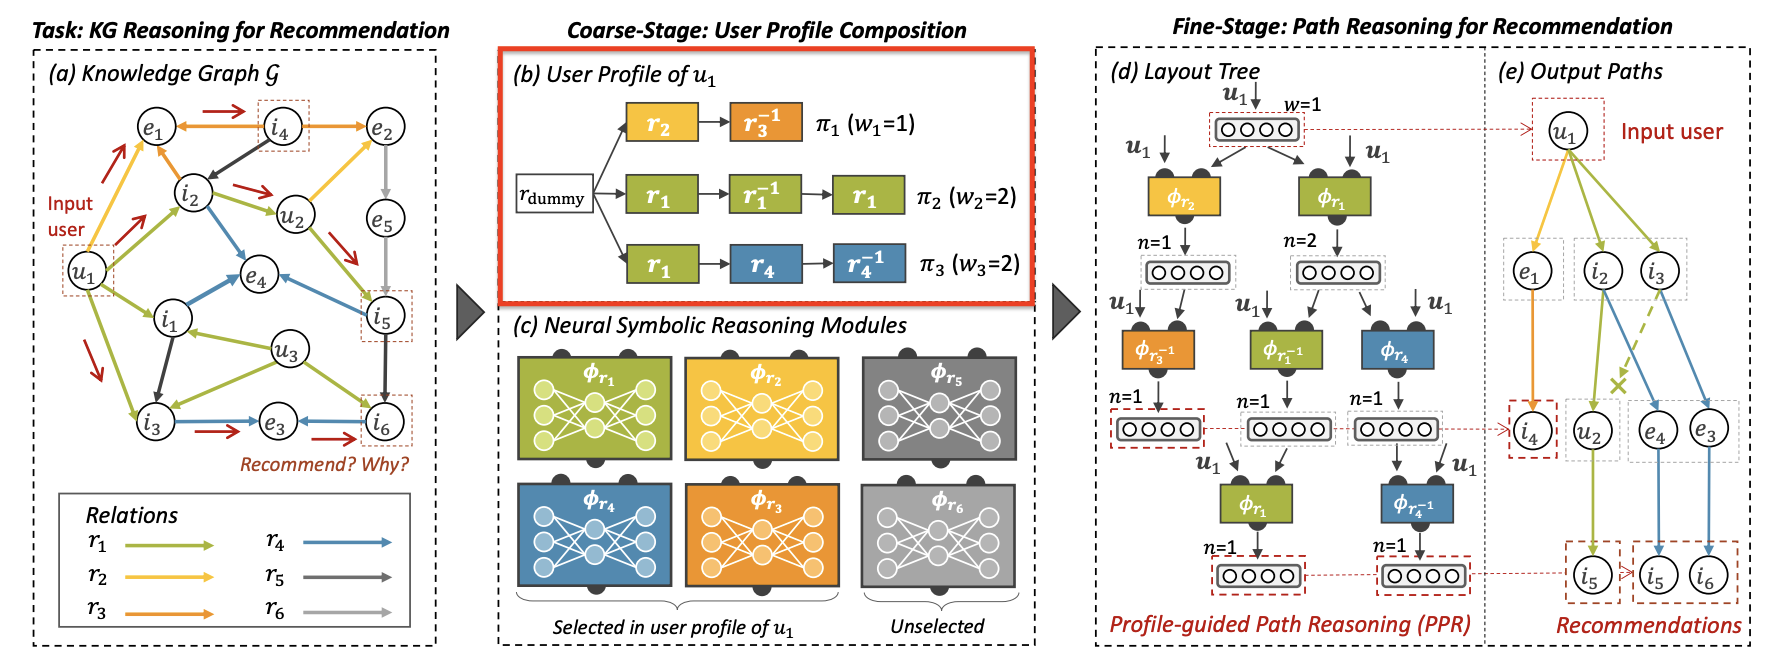

This process is carried on in two steps:

1. Firstly, using a **random walked base algorithm** [[33]](#p33) to produce a set of M user centric patterns $\Pi$ .

2. Then, selecting a subset of $\Pi$ and assigning
weights that reflect the prominent behaviors for each user.

This weight is based on the prominence $V_{\Theta}(u, \pi)$ be the prominence of a user-centric pattern $\pi$ for user $u$. Hence, $V_{\Theta}(u, \pi)$ is defined as the likelihood of “correct” paths being generated by
the reasoning model $\phi$.

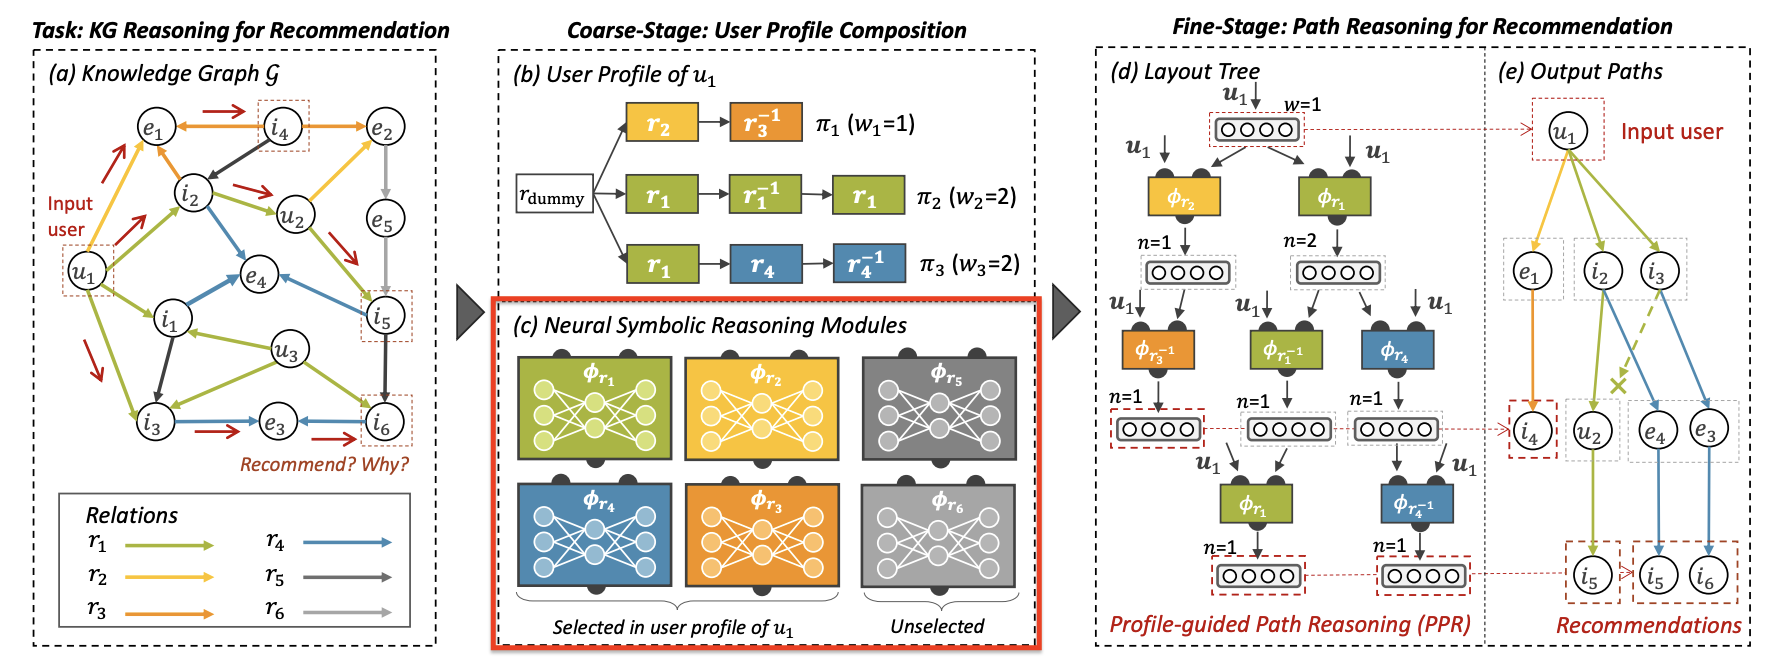

Using the prominence $V_{\Theta}(u, \pi)$, Cafe uses a heuristic method to select prominent patterns to **compose the profile for each user.**
Specifically, the goal is to determine the weights ${w_1, \dots, w_M}$ of
candidate patterns in $\Pi$ and **only the patterns with positive weights
are kept.**

The path reasoning relies on a one-step reasoner $\phi$. It determines the $t$ step action by estimating the **probability** $P_{\Theta}(r_t, e_t | u, h_t)$ of chosing an outgoing edge $(r_t, e_t)$ given the user $u$ and its **trajectory** $h_t = \{r_1, e_1, \dots, r_{t-1}, e_{t-1}\}$.

We can learn the policy by executing `train_neural_symbolic.py`.

The train_agent hyperparameter list is reported as follow:
- `--epochs`: Max number of epochs.
- `--batch_size`: Batch size.
- `--lr`: Learning rate.
- `--deep_module`: Use deep module or not.
- `--embed_size`: KG embedding size.
- `use_dropout`: use dropout or not.
- `rank_weight`: weighting factor for ranking loss.
- `topk_candidates`: weighting factor for ranking loss.

For simplicity **we have already set the values** so we can just run the script indicating the `dataset_name`.

⚠️ We have already execute the **preprocessing all datasets**. So you **don't need** to run this command now. The `symbolic_model_epoch20.ckpt` file will be store in `weights/{dataset_name}/cafe/tmp/neural_symbolic_model`

⏲️ Estimate time: 20m with `ML1M`

In [ ]:
! python pathlm/models/rl/CAFE/train_neural_symbol.py --dataset {dataset_name}

In [ ]:
! ls data/{dataset_name}/preprocessed/cafe/tmp/

cafe_hparams_file.json	embed.pkl  kg.pkl  path_count.pkl  user_products_pos.npy


## 4.4 Extract paths

---

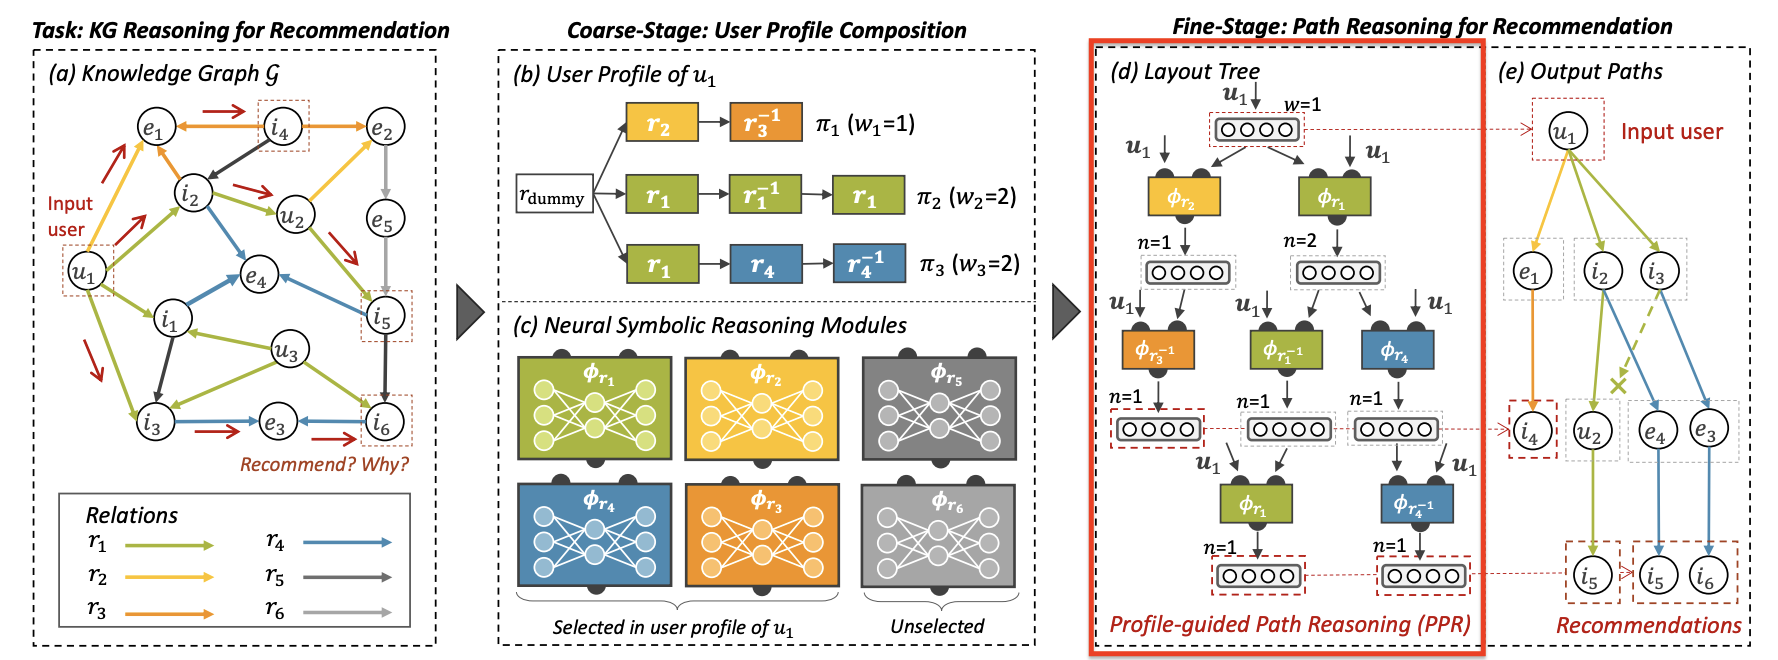

We can extract the paths from the policy running `execute_neural_symbol.py`.

The test_agent hyperparameter list is reported as follow:
- `--sample_size`: sample size for model.
- `--do_infer`: Whether to infer paths after training.
- `--do_execute`: Whether to execute neural programs.

For simplicity we have **already set the values** so we can just run the script indicating the `dataset_name`.

⚠️ We have already the **precomputed policy for all datasets**. So you **don't need** to run this command now. The `infer_path_data.pkl` file will be stored in `weights/{dataset_name}/cafe`

⏲️ Estimate time: 25m with `ML1M`

In [ ]:
! python pathlm/models/rl/CAFE/execute_neural_symbol.py --dataset {dataset_name} --do_infer True --do_execute False

Again the predicted paths stored in `infer_path_data.pkl` have been sorted base on probability and used to create the top`k` (`k`=10) of items and paths which will be store in `results/dataset/cafe`.

In [ ]:
! ls weights/{dataset_name}/cafe

ckpt  infer_path_data.pkl  program_exe_heuristic_ss50.txt  symbolic_model_epoch20.ckpt	tmp


✅ We are done! Let's now evaluate the performance of our model

## 4.5 Evaluating Results

---

In [ ]:
cafe_results_path = f"results/{dataset_name}/{curr_model}"

This paths are sorted by path score to produce the final topk of predicted item stored in `results/<dataset>/pgpr/top{k}_items.pkl`

In [ ]:
with open(f"{cafe_results_path}/top10_items.pkl", 'rb') as pred_top_items_file:
    cafe_item_topks = pickle.load(pred_top_items_file)
pred_top_items_file.close()

In [ ]:
list(cafe_item_topks.items())[:5]

[(0, [2336, 2454, 167, 2887, 522, 1547, 322, 1440, 1226, 867]),
 (1, [2235, 1440, 1329, 1359, 1560, 2165, 2102, 1048, 781, 1188]),
 (2, [1854, 1329, 2215, 781, 422, 1249, 2261, 1969, 2906, 2235]),
 (3, [763, 422, 2235, 466, 1329, 1694, 2906, 2261, 1547, 2542]),
 (4, [2235, 2712, 451, 2435, 1697, 2102, 1248, 2069, 2371, 2240])]

And the associated explanations store in `results/<dataset>/pgpr/top{k}_paths.pkl`

In [ ]:
with open(f"{cafe_results_path}/top10_paths.pkl", 'rb') as pred_top_paths_file:
    cafe_path_topks = pickle.load(pred_top_paths_file)
pred_top_paths_file.close()

In [ ]:
list(cafe_path_topks.items())[0]

(0,
 [(-11.300011,
   -5.1110687,
   [('self_loop', 'user', 0),
    ('watched', 'product', 763),
    ('starred_by_actor', 'actor', 19),
    ('rev_starred_by_actor', 'product', 2336)]),
  (-11.600761,
   -5.247924,
   [('self_loop', 'user', 0),
    ('watched', 'product', 2215),
    ('starred_by_actor', 'actor', 685),
    ('rev_starred_by_actor', 'product', 2454)]),
  (-11.7333975,
   -5.696994,
   [('self_loop', 'user', 0),
    ('watched', 'product', 763),
    ('belong_to_category', 'category', 5),
    ('rev_belong_to_category', 'product', 167)]),
  (-11.750533,
   -5.3976955,
   [('self_loop', 'user', 0),
    ('watched', 'product', 2215),
    ('starred_by_actor', 'actor', 685),
    ('rev_starred_by_actor', 'product', 2887)]),
  (-11.858136,
   -5.590087,
   [('self_loop', 'user', 0),
    ('watched', 'product', 763),
    ('belong_to_category', 'category', 37),
    ('rev_belong_to_category', 'product', 522)]),
  (-12.045703,
   -6.0092993,
   [('self_loop', 'user', 0),
    ('watched', 'p

In [ ]:
! python pathlm/evaluation/evaluate_results.py --dataset {dataset_name} --model {curr_model} --k 10

Evaluating rec quality for ['ndcg', 'mrr', 'precision', 'recall', 'serendipity', 'diversity', 'novelty']: 100% 6040/6040 [00:00<00:00, 11300.21it/s]
Number of users: 6040, average topk size: 10.00
ndcg: 0.27, mrr: 0.21, precision: 0.09, recall: 0.03, serendipity: 0.72, diversity: 0.86, novelty: 0.92, coverage: 0.2


## 4.6 Textual Explanation generation

---


Let's convert the explanation paths to textual explanations! Let's use the previously defined `template` function and `eid2name` map.

In [ ]:
import collections
cafe_exp_topks = collections.defaultdict(list)
random.seed(2024)
random_user = random.randint(0, len(cafe_path_topks.keys()))
for i, pid_exp_tuple in enumerate(cafe_path_topks[random_user]):
    prob, score, exp = pid_exp_tuple
    cafe_exp_topks[random_user].append([exp[-1][-1], template(exp)])

In [ ]:
cafe_exp_topks[random_user]

[[763,
  'You may be interested in http://dbpedia.org/resource/The_Sixth_Sense because you watched http://dbpedia.org/resource/Being_John_Malkovich also rev_belong_to_category by http://dbpedia.org/resource/Category:1999_films'],
 [2200,
  "You may be interested in http://dbpedia.org/resource/The_General's_Daughter_(film) because you watched http://dbpedia.org/resource/Being_John_Malkovich also rev_composed_by_composer by http://dbpedia.org/resource/Carter_Burwell"],
 [2454,
  'You may be interested in http://dbpedia.org/resource/The_Talented_Mr._Ripley_(film) because you watched http://dbpedia.org/resource/Being_John_Malkovich also rev_belong_to_category by http://dbpedia.org/resource/Category:1999_films'],
 [371,
  'You may be interested in http://dbpedia.org/resource/The_Bone_Collector because you watched http://dbpedia.org/resource/Being_John_Malkovich also rev_belong_to_category by http://dbpedia.org/resource/Category:1999_films'],
 [2848,
  "You may be interested in http://dbpedi

You can notice that in this example and as evidenced by previous studies [[36]](#p36) CAFE produces more diverse explanations in term of type of relations used in a topk

✅ We are done with this notebook!

# References

<a name="p1">[1]</a> F. Maxwell Harper, Joseph A. Konstan:
The MovieLens Datasets: History and Context. ACM Trans. Interact. Intell. Syst. 5(4): 19:1-19:19 (2016)

<a name="p2">[2]</a> Markus Schedl: The LFM-1b Dataset for Music Retrieval and Recommendation. ICMR 2016: 103-110

<a name="p3">[3]</a> Sören Auer, Christian Bizer, Georgi Kobilarov, Jens Lehmann, Richard Cyganiak, Zachary G. Ives:
DBpedia: A Nucleus for a Web of Open Data. ISWC/ASWC 2007: 722-735

<a name="p4">[4]</a> Denny Vrandecic, Markus Krötzsch:
Wikidata: a free collaborative knowledgebase. Commun. ACM 57(10): 78-85 (2014)

<a name="p5">[5]</a> Yixin Cao, Xiang Wang, Xiangnan He, Zikun Hu, Tat-Seng Chua:
Unifying Knowledge Graph Learning and Recommendation: Towards a Better Understanding of User Preferences. WWW 2019: 151-161


<a name="p6">[6]</a> Qingyao Ai, Vahid Azizi, Xu Chen, Yongfeng Zhang:
Learning Heterogeneous Knowledge Base Embeddings for Explainable Recommendation. Algorithms 11(9): 137 (2018)

<a name="p7">[7]</a> Kurt D. Bollacker, Colin Evans, Praveen K. Paritosh, Tim Sturge, Jamie Taylor:
Freebase: a collaboratively created graph database for structuring human knowledge. SIGMOD Conference 2008: 1247-1250

<a name="p8">[8]</a> Wayne Xin Zhao, Gaole He, Kunlin Yang, Hongjian Dou, Jin Huang, Siqi Ouyang, Ji-Rong Wen:
KB4Rec: A Data Set for Linking Knowledge Bases with Recommender Systems. Data Intell. 1(2): 121-136 (2019)

<a name="p9">[9]</a> Yongfeng Zhang, Qingyao Ai, Xu Chen, W. Bruce Croft:
Joint Representation Learning for Top-N Recommendation with Heterogeneous Information Sources. CIKM 2017: 1449-1458

<a name="p10">[10]</a> Yikun Xian, Zuohui Fu, S. Muthukrishnan, Gerard de Melo, Yongfeng Zhang:
Reinforcement Knowledge Graph Reasoning for Explainable Recommendation. SIGIR 2019: 285-294

<a name="p11">[11]</a> Antoine Bordes, Nicolas Usunier, Alberto García-Durán, Jason Weston, Oksana Yakhnenko:
Translating Embeddings for Modeling Multi-relational Data. NIPS 2013: 2787-2795

<a name="p12">[12]</a> Yikun Xian, Zuohui Fu, Handong Zhao, Yingqiang Ge, Xu Chen, Qiaoying Huang, Shijie Geng, Zhou Qin, Gerard de Melo, S. Muthukrishnan, Yongfeng Zhang:
CAFE: Coarse-to-Fine Neural Symbolic Reasoning for Explainable Recommendation. CIKM 2020: 1645-1654

<a name="p13">[13]</a> Zhu Sun, Jie Yang, Jie Zhang, Alessandro Bozzon, Long-Kai Huang, Chi Xu:
Recurrent knowledge graph embedding for effective recommendation. RecSys 2018: 297-305

<a name="p14">[14]</a> Hongwei Wang, Fuzheng Zhang, Miao Zhao, Wenjie Li, Xing Xie, Minyi Guo:
Multi-Task Feature Learning for Knowledge Graph Enhanced Recommendation. CoRR abs/1901.08907 (2019)

<a name="p15">[15]</a> Xiang Wang, Tinglin Huang, Dingxian Wang, Yancheng Yuan, Zhenguang Liu, Xiangnan He, Tat-Seng Chua:
Learning Intents behind Interactions with Knowledge Graph for Recommendation. WWW 2021: 878-887

<a name="p16">[16]</a> Song, Weiping, Zhijian Duan, Ziqing Yang, Hao Zhu, Ming Zhang, and Jian Tang. "Explainable knowledge graph-based recommendation via deep reinforcement learning." arXiv preprint arXiv:1906.09506 (2019).

<a name="p17">[17]</a>	Hongwei Wang, Fuzheng Zhang, Jialin Wang, Miao Zhao, Wenjie Li, Xing Xie, Minyi Guo:
RippleNet: Propagating User Preferences on the Knowledge Graph for Recommender Systems. CIKM 2018: 417-426

<a name="p18">[18]</a> Xiang Wang, Dingxian Wang, Canran Xu, Xiangnan He, Yixin Cao, Tat-Seng Chua:
Explainable Reasoning over Knowledge Graphs for Recommendation. AAAI 2019: 5329-5336

<a name="p19">[19]</a> Binbin Hu, Chuan Shi, Wayne Xin Zhao, Philip S. Yu: Leveraging Meta-path based Context for Top- N Recommendation with A Neural Co-Attention Model. KDD 2018: 1531-1540

<a name="p20">[20]</a>
Chuan Shi, Binbin Hu, Wayne Xin Zhao, Philip S. Yu:
Heterogeneous Information Network Embedding for Recommendation. CoRR abs/1711.10730 (2017)

<a name="p21">[21]</a> Xiaowen Huang, Quan Fang, Shengsheng Qian, Jitao Sang, Yan Li, Changsheng Xu:
Explainable Interaction-driven User Modeling over Knowledge Graph for Sequential Recommendation. ACM Multimedia 2019: 548-556

<a name="p22">[22]</a> Song, Weiping, et al. "Explainable knowledge graph-based recommendation via deep reinforcement learning." arXiv preprint arXiv:1906.09506 (2019).

<a name="p23">[23]</a> Chang-You Tai, Liang-Ying Huang, Chien-Kun Huang, Lun-Wei Ku:
User-Centric Path Reasoning towards Explainable Recommendation. SIGIR 2021: 879-889

<a name="p24">[24]</a> Xiting Wang, Kunpeng Liu, Dongjie Wang, Le Wu, Yanjie Fu, Xing Xie:
Multi-level Recommendation Reasoning over Knowledge Graphs with Reinforcement Learning. WWW 2022: 2098-2108

<a name="p25">[25]</a> Danyang Liu, Jianxun Lian, Zheng Liu, Xiting Wang, Guangzhong Sun, Xing Xie:
Reinforced Anchor Knowledge Graph Generation for News Recommendation Reasoning. KDD 2021: 1055-1065

<a name="p26">[26]</a> Zhen Wang, Jianwen Zhang, Jianlin Feng, Zheng Chen:
Knowledge Graph Embedding by Translating on Hyperplanes. AAAI 2014: 1112-

<a name="p27">[27]</a> Zhiqing Sun, Zhi-Hong Deng, Jian-Yun Nie, Jian Tang:
RotatE: Knowledge Graph Embedding by Relational Rotation in Complex Space. ICLR (Poster) 2019

<a name="p28">[28]</a>  Yankai Lin, Zhiyuan Liu, Maosong Sun, Yang Liu, Xuan Zhu:
Learning Entity and Relation Embeddings for Knowledge Graph Completion. AAAI 2015: 2181-2187

<a name="p29">[29]</a>  Tim Dettmers, Pasquale Minervini, Pontus Stenetorp, Sebastian Riedel:
Convolutional 2D Knowledge Graph Embeddings. AAAI 2018: 1811-1818

<a name="p30">[30]</a> Ni Lao, Tom M. Mitchell, William W. Cohen:
Random Walk Inference and Learning in A Large Scale Knowledge Base. EMNLP 2011: 529-539


<a name="p31">[31]</a> Yining Wang, Liwei Wang, Yuanzhi Li, Di He, Tie-Yan Liu:
A Theoretical Analysis of NDCG Type Ranking Measures. COLT 2013: 25-54

<a name="p32">[32]</a> Giacomo Balloccu, Ludovico Boratto, Gianni Fenu, and Mirko Marras. 2022. Post Processing Recommender Systems with Knowledge Graphs for Recency, Popularity, and Diversity of Explanations. In Proceedings of the 45th International ACM SIGIR Conference on Research and Development in Information Retrieval (SIGIR '22). Association for Computing Machinery, New York, NY, USA, 646–656. https://doi.org/10.1145/3477495.3532041

<a name="p33">[33]</a> Balloccu G, Boratto L, Fenu G, Marras M. Reinforcement recommendation reasoning through knowledge graphs for explanation path quality. Knowledge-Based Systems. 2023 Jan 25;260:110098.

<a name="p34">[34]</a> Dessì D, Fenu G, Marras M, Reforgiato Recupero D. Coco: Semantic-enriched collection of online courses at scale with experimental use cases. InTrends and Advances in Information Systems and Technologies: Volume 2 6 2018 (pp. 1386-1396). Springer International Publishing.

<a name="p35">[35]</a>  Ni J, Li J, McAuley J. Justifying recommendations using distantly-labeled reviews and fine-grained aspects. InProceedings of the 2019 conference on empirical methods in natural language processing and the 9th international joint conference on natural language processing (EMNLP-IJCNLP) 2019 Nov (pp. 188-197).

<a name="p36">[36]</a> Balloccu G, Boratto L, Cancedda C, Fenu G, Marras M. Knowledge is power, understanding is impact: Utility and beyond goals, explanation quality, and fairness in path reasoning recommendation. InEuropean Conference on Information Retrieval 2023 Mar 16 (pp. 3-19). Cham: Springer Nature Switzerland.

<a name="p37">[37]</a> Geng S, Fu Z, Tan J, Ge Y, De Melo G, Zhang Y. Path language modeling over knowledge graphsfor explainable recommendation. InProceedings of the ACM Web Conference 2022 2022 Apr 25 (pp. 946-955).

<a name="p38">[38]</a> Balloccu G, Boratto L, Cancedda C, Fenu G, Marras M. Faithful Path Language Modelling for Explainable Recommendation over Knowledge Graph. arXiv preprint arXiv:2310.16452. 2023 Oct 25.

<a name="p39">[39]</a> Afreen N, Balloccu G, Boratto L, Fenu G, Marras M. Towards explainable educational recommendation through path reasoning methods. InCEUR WORKSHOP PROCEEDINGS 2023 (Vol. 3448, pp. 131-136). CEUR-WS.